train.csv :
·      area_type: The type of the house area feature 'total_sqft' specifies.
·      availability: The availability date or availability status of the property.
·      location: The locality of the property in Bengaluru city.
·      size: The size of the housing property in BHK (or Bedrooms etc.,).
·      society: The name of the Apartment. This name is encrypted for confidentiality.
·      total_sqft: The 'area_type' area of the property.
·      bath: Number of bathrooms available in the house.
·      balcony: Number of balcony/balconies the house has.
·      price: Price of the housing property in Lakhs. (target feature)
 
The `test.csv` dataset contains similar information to train.csv but does not disclose the “price” feature. The price has to be predicted through your model.
 
avg_rent.csv :
·      location : The locality of the property in the bengaluru city.
·      avg_2bhk_rent : Average rent of two BHK flat in that location
 
 
dist_from_city_centre.csv : 
·      location : The locality of the property in the bengaluru city.
·      dist_from_city : Distance of the location from city center

In [295]:
import numpy as np 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
matplotlib.rcParams['font.family'] = "Arial"

%matplotlib inline
import collections
import itertools
import scipy.stats as stats
from scipy.stats import norm
from scipy.special import boxcox1p
import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
#print(statsmodels.__version__)
from sklearn.preprocessing import scale, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.utils import resample

import warnings

warnings.filterwarnings("ignore")

In [296]:
df = pd.read_csv("train.csv")
df_rent = pd.read_csv("avg_rent.csv")
df_dist = pd.read_csv("dist_from_city_centre.csv")
df_rent.head()

,location,avg_2bhk_rent
0,Krishnarajapura,11954
1,Sarjapur,45000
2,Whitefield Hope Farm Junction,26370
3,Devanahalli,17302
4,Whitefield,14981


In [297]:
df.head()

,ID,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


## PRELIMINARY CLEAN-UPS

In [298]:
# Dropping the ID column for its redundancy
df.drop(columns=["ID", "society"], inplace=True)

In [299]:
num_df = df.select_dtypes(include=np.number)

num_df.head()

,bath,balcony,price
0,2.0,1.0,39.07
1,5.0,3.0,120.00
2,2.0,3.0,62.00
3,3.0,1.0,95.00
4,2.0,1.0,51.00


In [300]:
# Correcting the data_type of total_sqft
df.total_sqft.dtype

dtype('O')

In [301]:
df.total_sqft.value_counts()

1200         667
1100         178
2400         163
1500         154
600          150
            ... 
722            1
35000          1
520 - 645      1
451            1
2416           1
Name: total_sqft, Length: 1923, dtype: int64

In [302]:
df.loc[df["total_sqft"]=="1650 - 2538"]

,area_type,availability,location,size,total_sqft,bath,balcony,price
4346,Super built-up Area,18-Dec,Whitefield,3 BHK,1650 - 2538,NaN,NaN,113.19


In cases where the total-sqft is in ranges, taking average value for the total_sqft at that price. And for rows containing area in Acres, we can convert them to same unit.

In [303]:
import re 
df['total_sqft_is_alphanumeric'] = list(map(lambda x: re.search(r'[a-zA-Z]',x) != None, df['total_sqft']))

We can see that there are multiple units which are used here:
SqMeter/Acres/SqYards/Grounds/Cents/Guntha/Perch

Using calculators from https://housing.com/calculators/ground-to-square-feet
* 1 Ground =  2400.352024 sq.ft
* 1 Perch = 272.25 sq.ft
* 1 acre = 43560.00001 sq.ft
* 1 Guntha = 1089 sq.ft
* 1 sq.yards = 9.000000878 sq.ft
* 1 sq.meters = 10.76391042 sq.ft
* 1 Cents = 435.56 sq.ft

In [304]:
def return_in_sq_ft(value, units):
    units = units.lower()
    value=float(value)
    if units=="grounds":
        return value*2400.352024
    elif units=="perch":
        return value*272.25
    elif units=="acres":
        return value*43560.00001
    elif units=="guntha":
        return value*1089
    elif units=="sq.yards":
        return value*9.000000878
    elif units=="sq.meter":
        return value*10.76391042
    elif units=="cents":
        return value*435.56
    else:
        print(f"{units} not FOUND")

def units_in_sq_ft(value):
    if re.search(r'[a-zA-Z]',value) != None:
        
        s_arr = re.findall(r'\d+[.]?\d*|[A-Za-z.]+', value)
        return return_in_sq_ft(s_arr[0], "".join(s_arr[1:]))
    elif value.find("-")!=-1:
        return (float(value.split("-")[0])+float(value.split("-")[1]))/2
    else:
        return float(value)

df["total_sqft_1"] = df["total_sqft"].apply(units_in_sq_ft)

In [305]:
num_df = df.select_dtypes(include=np.number)

num_df.head()

,bath,balcony,price,total_sqft_1
0,2.0,1.0,39.07,1056.0
1,5.0,3.0,120.00,2600.0
2,2.0,3.0,62.00,1440.0
3,3.0,1.0,95.00,1521.0
4,2.0,1.0,51.00,1200.0


In [306]:
df.head()

,area_type,availability,location,size,total_sqft,bath,balcony,price,total_sqft_is_alphanumeric,total_sqft_1
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,1056,2.0,1.0,39.07,False,1056.0
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,120.00,False,2600.0
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,1440,2.0,3.0,62.00,False,1440.0
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,1521,3.0,1.0,95.00,False,1521.0
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,1200,2.0,1.0,51.00,False,1200.0


In [307]:
# Dropping the redundant columns total_sqft and total_sqft_is_alphanumeric
df.drop(columns=["total_sqft", "total_sqft_is_alphanumeric"], inplace=True)

# Renaming the total_sqft_1 column without the suffix
df.rename(columns={"total_sqft_1":"total_sqft"},inplace=True)

## FINDING ALL THE MISSING VALUES AND FIXING THEM

In [308]:
print(df.shape)
df.isnull().sum()

(10656, 8)


area_type         0
availability      0
location          1
size             14
bath             65
balcony         504
price             0
total_sqft        0
dtype: int64

50% of data for Society is missing. It can be either of two reasons. Either the data is missing. Or the property doesnt belong to a society.

In [309]:
# df.groupby('society').agg('std')

In [310]:
# Since multiple rows of single society exist, lets try not to drop it. Mark all rows with no-society as ~Independent
# df['society'].fillna("Independent", inplace=True)

<AxesSubplot:>

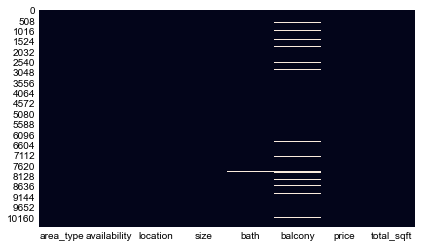

In [311]:
# Check for null values in a heatmap
sns.heatmap(df.isna(), cbar=False)

In [312]:
### Trying to figure out how to fill missing values of balcony

<AxesSubplot:>

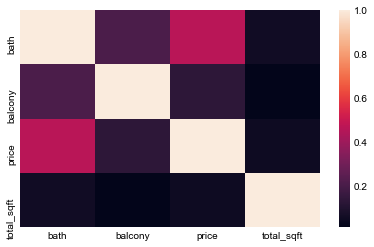

In [313]:
sns.heatmap(df.corr())

Balcony is correlated with Total_sqft. Average size of balconies in Bangalore is 24 sqft.
Ref: https://www.99acres.com/articles/how-crucial-is-the-balcony-size-for-home-buyers.html

Finding the ratio of total_sqft with total area of balconies

43.72841568447607


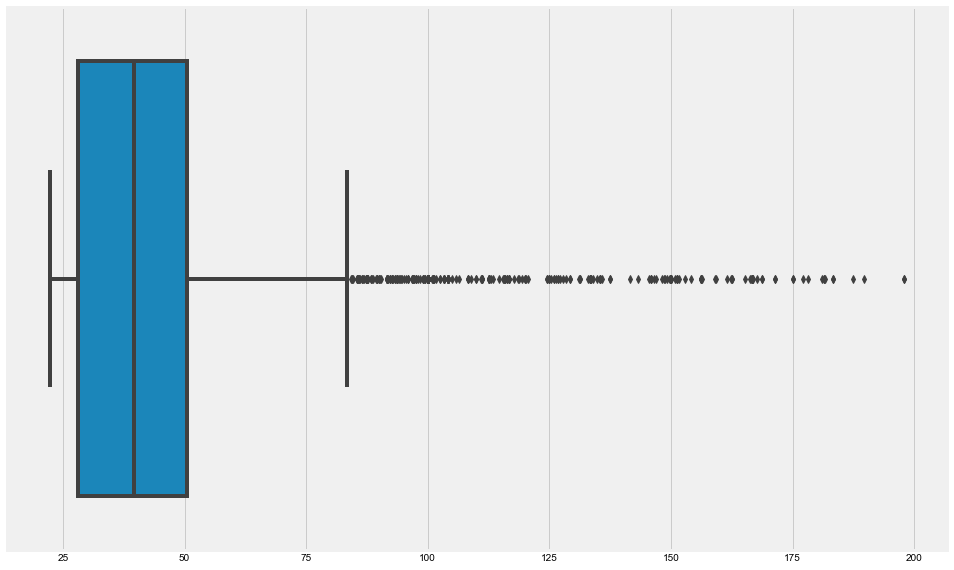

In [314]:
STANDARD_BALCONY_SIZE = 24
df["balcony"].fillna(0)
df["ratio_balcony_area_with_total_area"] = df["total_sqft"]/(df["balcony"]*STANDARD_BALCONY_SIZE)
plt.figure(figsize=(15,10))
ratio_balcony_area_with_total_area = df['ratio_balcony_area_with_total_area']
ratio_balcony_area_with_total_area = stats.trimboth(ratio_balcony_area_with_total_area,0.13)
mean_ratio = ratio_balcony_area_with_total_area.mean()
sns.boxplot(x=ratio_balcony_area_with_total_area)
print(mean_ratio)

Dividing this mean_ratio with the total_square_ft will give the count of balconies for all those rows where data is missing.

<AxesSubplot:>

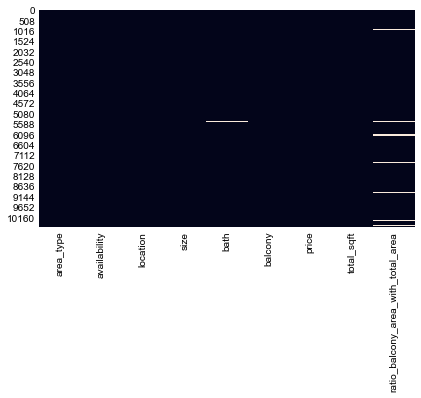

In [315]:
for index, col in enumerate(df['balcony']):
    if np.isnan(df.loc[index,'balcony']):
        df.loc[index,'balcony']=round(df.loc[index,'total_sqft']/mean_ratio,0)
        
# Check for null values in a heatmap
sns.heatmap(df.isna(), cbar=False)

In [316]:
# Dropping the ratio column
df.drop(columns=["ratio_balcony_area_with_total_area"], inplace=True)

## SORTING THE DATA FOR SQFT AND SIZE

In [317]:
avg_price_roomwise = pd.DataFrame()
# Converting the output of GroupBy to Dataframe using to_frame()
avg_price_roomwise = df.groupby("size").agg('mean').reset_index()
avg_price_roomwise

,size,bath,balcony,price,total_sqft
0,1 BHK,1.058140,1.043678,39.727471,694.114194
1,1 Bedroom,1.125000,0.340909,70.460795,5481.890592
2,1 RK,1.000000,0.461538,28.122308,493.192308
3,10 BHK,12.000000,182.500000,342.500000,8000.000000
4,10 Bedroom,9.250000,33.625000,297.500000,1615.750000
5,11 BHK,10.500000,70.000000,255.000000,5500.000000
6,11 Bedroom,8.500000,1.500000,160.000000,1200.000000
7,12 Bedroom,6.000000,2.000000,300.000000,2232.000000
8,13 BHK,13.000000,0.000000,275.000000,5425.000000
9,14 BHK,15.000000,0.000000,125.000000,1250.000000


In [318]:
get_room_count = lambda x: int(str(x).split()[0])

In [319]:
avg_price_roomwise['size_num_only'] = avg_price_roomwise['size'].apply(get_room_count)
avg_price_roomwise

,size,bath,balcony,price,total_sqft,size_num_only
0,1 BHK,1.058140,1.043678,39.727471,694.114194,1
1,1 Bedroom,1.125000,0.340909,70.460795,5481.890592,1
2,1 RK,1.000000,0.461538,28.122308,493.192308,1
3,10 BHK,12.000000,182.500000,342.500000,8000.000000,10
4,10 Bedroom,9.250000,33.625000,297.500000,1615.750000,10
5,11 BHK,10.500000,70.000000,255.000000,5500.000000,11
6,11 Bedroom,8.500000,1.500000,160.000000,1200.000000,11
7,12 Bedroom,6.000000,2.000000,300.000000,2232.000000,12
8,13 BHK,13.000000,0.000000,275.000000,5425.000000,13
9,14 BHK,15.000000,0.000000,125.000000,1250.000000,14


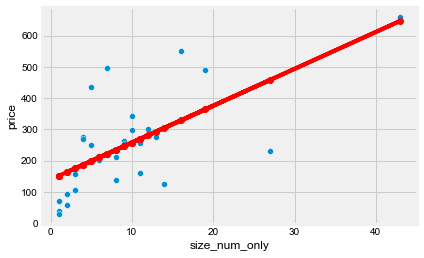

In [320]:
# Plotting the price with number of bedrooms
sns.scatterplot(x='size_num_only', y='price', data=avg_price_roomwise)
z=np.polyfit(avg_price_roomwise['size_num_only'], avg_price_roomwise['price'],1)
p = np.poly1d(z)
plt.plot(avg_price_roomwise['size_num_only'], p(avg_price_roomwise['size_num_only']), "r-o")

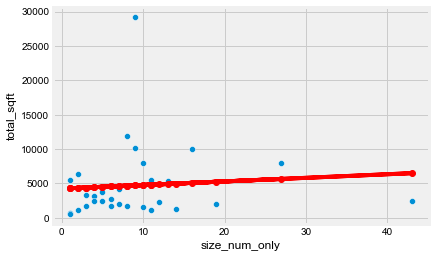

In [321]:
# Plotting the square feet area with number of bedrooms
sns.scatterplot(x='size_num_only', y='total_sqft', data=avg_price_roomwise)

z=np.polyfit(avg_price_roomwise['size_num_only'], avg_price_roomwise['total_sqft'],1)
p = np.poly1d(z)
plt.plot(avg_price_roomwise['size_num_only'], p(avg_price_roomwise['size_num_only']), "r-o")

The area of the properties are not increasing even if number of bedrooms are increasing

A major issue in this data is the total_sqft and size is not properly mapped. In some cases, the total_sqft is wrt area of the entire property, while in some cases, it only shows the area of the room.

Eg., for a 43 bedroom property, the total_sqft is 2400. While for 6 BHK, there are several properties whose sq_ft are > 2000 sqft. This looks suspicious.

In [322]:
# Selecting the non-null values for size alone
df = df[df['size'].notna()]

<AxesSubplot:xlabel='size_in_num', ylabel='count'>

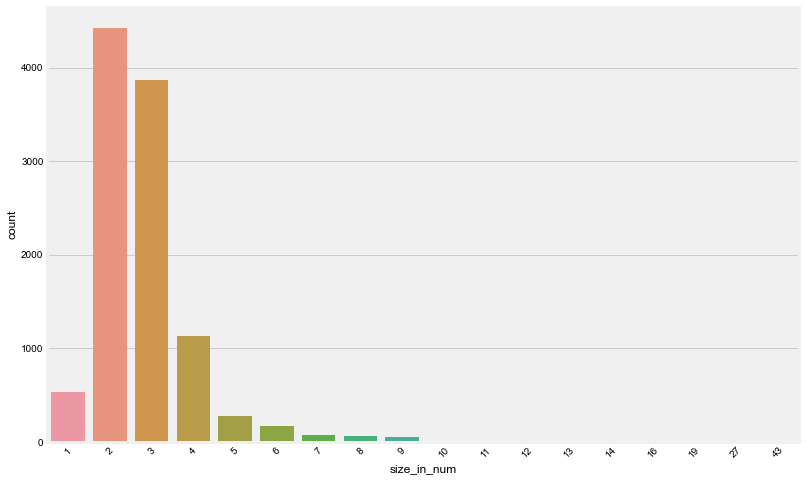

In [323]:
# Getting the count of houses for each category
df['size_in_num'] = df['size'].apply(get_room_count)
plt.figure(figsize=(12,8))
plt.xticks(rotation=45)
sns.countplot(x='size_in_num', data=df)

In [324]:
# Dropping size column
df.drop(columns=["size"], inplace=True)

In [325]:
df_clean = df.dropna()

In [326]:
df_clean.isnull().sum()

area_type       0
availability    0
location        0
bath            0
balcony         0
price           0
total_sqft      0
size_in_num     0
dtype: int64

## CHECKING FOR OUTLIERS

We are going to check for outliers only in the train data. Other data like avg_rest and dist_from_city_centre are complimentary information and so doesnt need any outlier detection

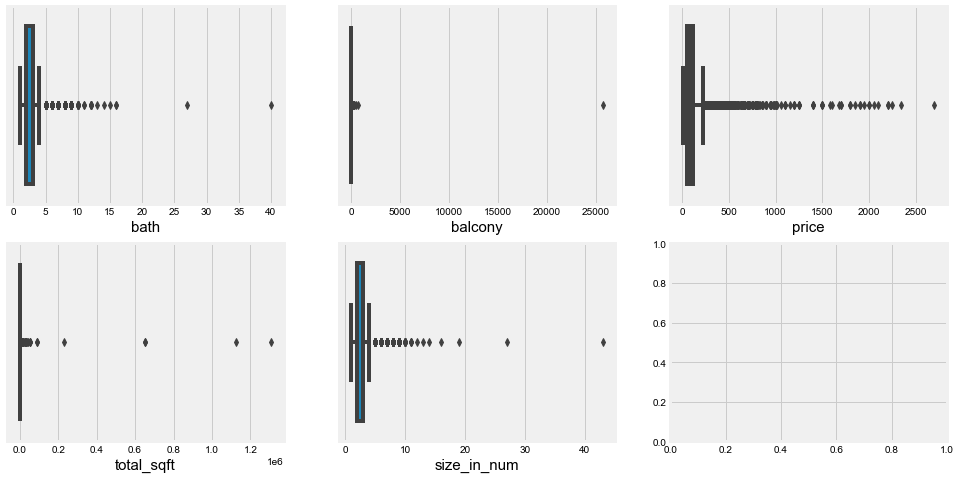

In [327]:
df_num = df_clean.select_dtypes(include=np.number)
fig,ax = plt.subplots(2,3, figsize=(15,8))

for col, sub in zip(df_num, ax.flatten()):
    z=sns.boxplot(x=df_num[col], ax=sub, orient='h')
    z.set_xlabel(col, fontsize=15)

<AxesSubplot:xlabel='log_price', ylabel='Density'>

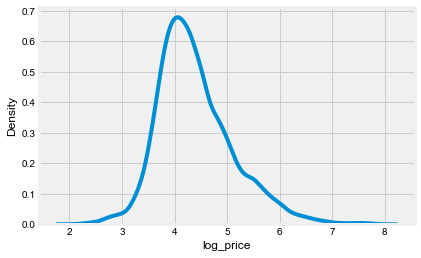

In [328]:
# There are a lot of entries in price which are outliers. Lets try to  transform this column first
df_clean['log_price'] = np.log(df_clean['price'])
sns.kdeplot(df_clean['log_price'])

<AxesSubplot:xlabel='price', ylabel='Density'>

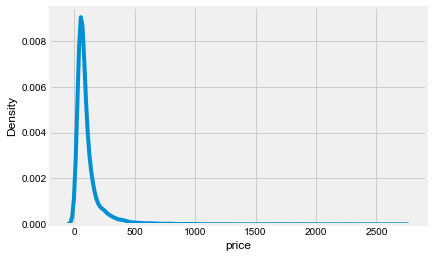

In [329]:
sns.kdeplot(df_clean['price'])

Log of Price column is way more normal. Lets lee, if it has any outliers now

<AxesSubplot:xlabel='log_price'>

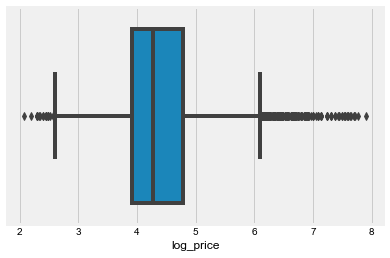

In [330]:
sns.boxplot(df_clean['log_price'])

In [331]:
# Creating a new Dataframe without price column
df_1 = df_clean.copy()

<AxesSubplot:xlabel='log_price'>

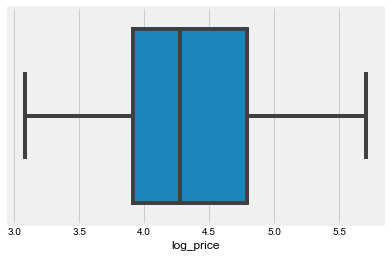

In [332]:
# Doing capping to replace the outliers with upper and lower margins
IQR = df_1['log_price'].quantile(0.75) - df_1['log_price'].quantile(0.25)
price_mean = df_1['log_price'].mean()
df_1['log_price'] = df_1['log_price'].apply(lambda x:(price_mean - 1.5*IQR) if x < (price_mean - 1.5*IQR) else (price_mean + 1.5*IQR) if x > price_mean + 1.5*IQR else x)
sns.boxplot(df_1['log_price'])

In [333]:
# Doing log transformation of other numeric columns as well
df_1_num = df_1.select_dtypes(include=np.number)
df_1_num.drop(columns=["log_price"], inplace=True)

In [334]:
df_1_num.isna().sum()

bath           0
balcony        0
price          0
total_sqft     0
size_in_num    0
dtype: int64

In [335]:
df_1_num.describe()

,bath,balcony,price,total_sqft,size_in_num
count,10590.000000,10590.000000,10590.000000,1.059000e+04,10590.000000
mean,2.690557,6.420963,111.985839,1.969132e+03,2.799339
std,1.352464,250.022523,142.297468,1.919882e+04,1.312622
min,1.000000,0.000000,8.000000,1.000000e+00,1.000000
25%,2.000000,1.000000,50.000000,1.100000e+03,2.000000
50%,2.000000,2.000000,72.000000,1.271000e+03,3.000000
75%,3.000000,2.000000,120.000000,1.677000e+03,3.000000
max,40.000000,25682.000000,2700.000000,1.306800e+06,43.000000


In [336]:
# It doesnt make sense to have 25000 balconies, also balcony doesnt have a lot of variation. Getting rid of this column
df_1_num.drop(columns=["balcony"], inplace=True)

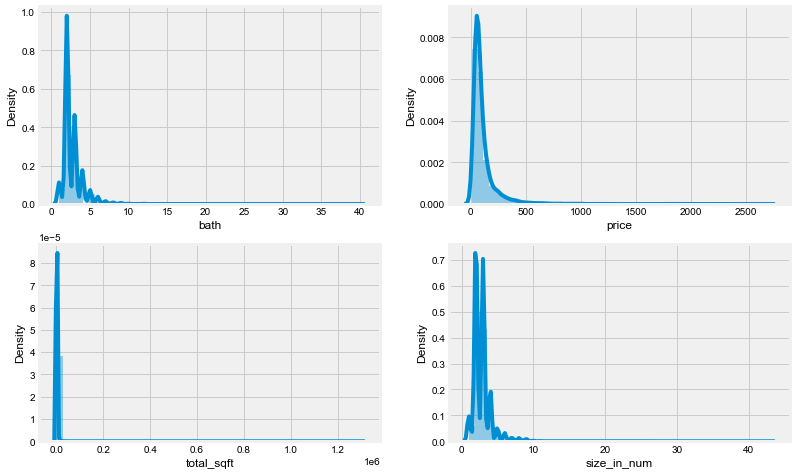

In [337]:
fig, ax = plt.subplots(2,2,figsize=(12,8))

for col, sub in zip(df_1_num, ax.flatten()):
    z = sns.distplot(df_1_num[col], ax=sub)
    z.set_xlabel(col)

In [338]:
# Capping the outliers
IQR = df_1_num.quantile(0.75) - df_1_num.quantile(0.25)
df_mean = df_1_num.mean()
print(IQR, df_mean)
IQR = pd.DataFrame(IQR)
df_mean = pd.DataFrame(df_mean)

bath             1.0
price           70.0
total_sqft     577.0
size_in_num      1.0
dtype: float64 bath              2.690557
price           111.985839
total_sqft     1969.131685
size_in_num       2.799339
dtype: float64


In [339]:
IQR.loc['bath'].values[0]

1.0

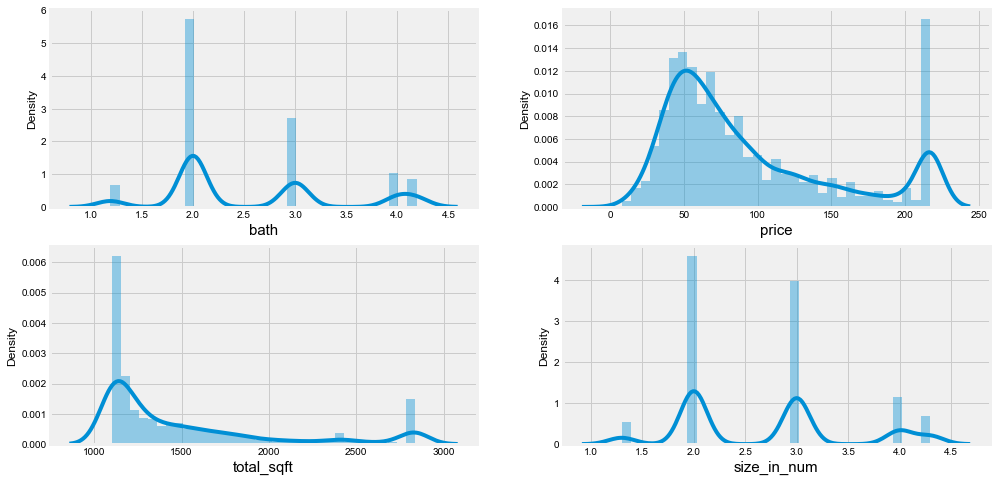

In [340]:
# Getting RID of outliers from all the columns
df_2_num = df_1_num.copy()

for col in df_2_num:

    df_2_num[col] = df_2_num[col].apply(
        lambda x:(
            df_mean.loc[col].values[0] - 1.5*IQR.loc[col].values[0]) if x < (df_mean.loc[col].values[0] - 1.5*IQR.loc[col].values[0]) else (df_mean.loc[col].values[0] + 1.5*IQR.loc[col].values[0]) if x > df_mean.loc[col].values[0] + 1.5*IQR.loc[col].values[0] else x
    )

fig,ax = plt.subplots(2,2, figsize=(15,8))

for col, sub in zip(df_2_num, ax.flatten()):
    z=sns.distplot(x=df_2_num[col], ax=sub,)
    z.set_xlabel(col, fontsize=15)
    

In [359]:
df_3_num = df_2_num.copy()
df_3_num['total_sqft'] = np.log(df_3_num['total_sqft'])
df_3 = pd.DataFrame()
df_3 = pd.concat([df_1.select_dtypes(exclude=np.number), df_3_num, df_1['log_price']], axis=1)
df_3.head()

,area_type,availability,location,bath,price,total_sqft,size_in_num,log_price
0,Super built-up Area,19-Dec,Electronic City Phase II,2.000000,39.07,7.006362,2.0,3.665355
1,Plot Area,Ready To Move,Chikka Tirupathi,4.190557,120.00,7.863267,4.0,4.787492
2,Built-up Area,Ready To Move,Uttarahalli,2.000000,62.00,7.272398,3.0,4.127134
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3.000000,95.00,7.327123,3.0,4.553877
4,Super built-up Area,Ready To Move,Kothanur,2.000000,51.00,7.090077,2.0,3.931826


### Exploratory Data Analysis

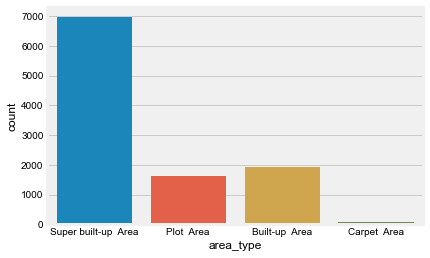

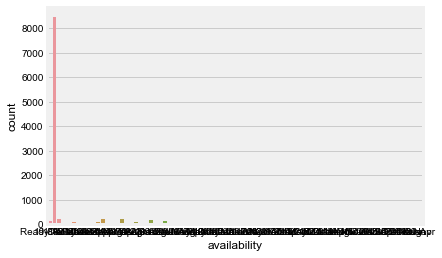

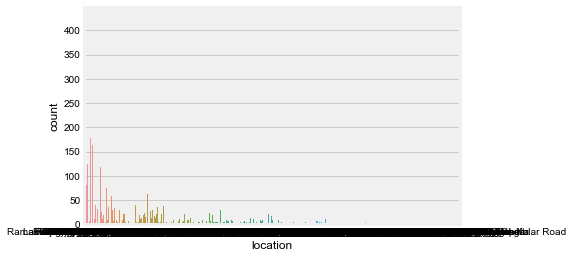

In [360]:
df_3_categ = df_3.select_dtypes(exclude=np.number)
for col in df_3_categ:
    sns.countplot(x=df_3_categ[col])
    plt.show()

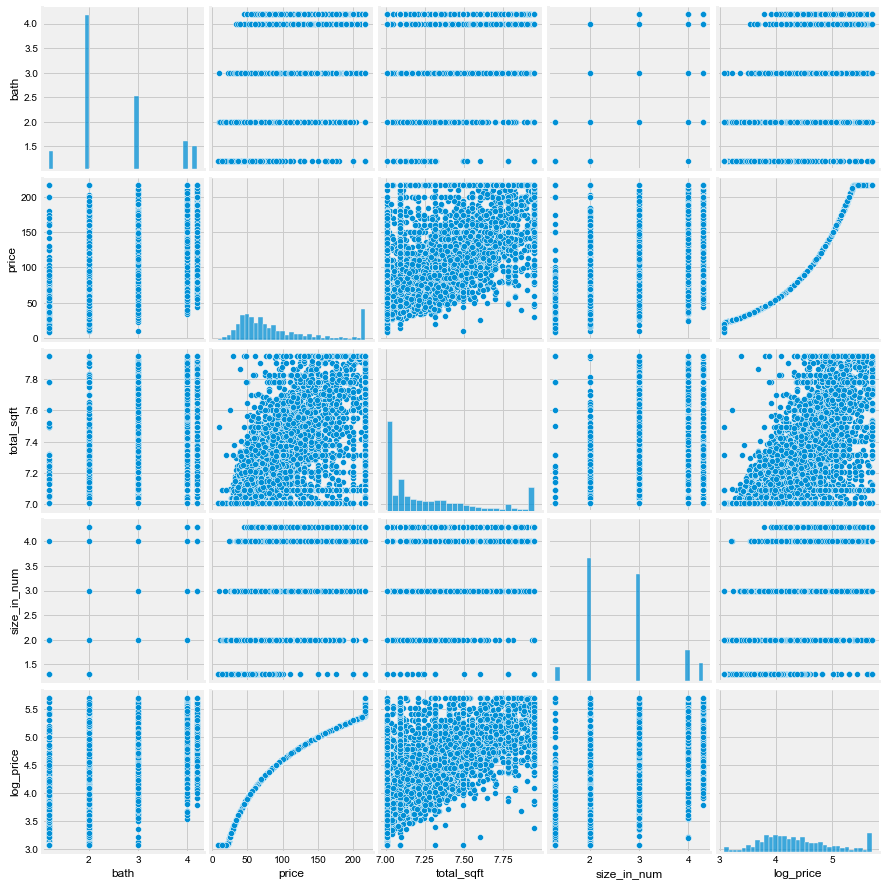

In [361]:
sns.pairplot(df_3)

Price and Total_Sqft are highly correlated.

### We will do following encoding for the categorical columns:

area_type: Ordinal encoding: Carpet Area:0, Built Up Area: 1, Super built Up Area: 2, Plot area: 3

Availabiity: Ready To Move: 1, anything else(Mostly Dates): 0

Location: Distance from City Centre

Society: Target encoding

Also for every Location, we will add the column for average rent in the area

In [362]:
ordinal_encoding_area_dict = {"Carpet  Area":0, "Built-up  Area":1, "Plot  Area":3, "Super built-up  Area":2}
df_3['area_type_encoded'] = df_3['area_type'].map(ordinal_encoding_area_dict)

In [363]:
df_3['availability_encoded'] = df_3['availability'].apply(lambda x: 1 if x=="Ready To Move" else 0)

In [364]:
mean_distance_of_localities = df_dist.dist_from_city.mean()

In [365]:
df_dist["location"] = df_dist["location"].apply(str.lower)


# If the location is not found, we will replace the value with average distance of all locations
def get_dist(location):
    if location in df_dist['location'].unique():
        return df_dist.loc[df_dist['location'] == location]['dist_from_city'].values[0]
    else:
        return mean_distance_of_localities

In [366]:
for index, row in df_3.iterrows():
    df_3.loc[index,['dist']] = get_dist(row["location"].lower())

In [349]:
# import category_encoders as ce 

# target_en = ce.TargetEncoder()
# df_society_enc = target_en.fit_transform(df_3['society'], df_3['log_price'],smoothing=50)
# df_4 = df_society_enc.join(df_3.drop(columns="society"))

In [350]:
# Adding average rent for location

# df_rent["location"] = df_rent["location"].apply(str.lower)

# def get_avg_rent(location):
#     return df_rent.loc[df_rent["location"]==location.lower(), "avg_2bhk_rent"].values[0] if location.lower() in df_rent['location'].unique() else "NF"

# for index, row in df_4.iterrows(): 
#     df_4.loc[index, ['avg_rent']] = get_avg_rent(row["location"])



In [351]:
# df_4[df_4['avg_rent']=="NF"].shape[0]

In [368]:
df_3.head()

,area_type,availability,location,bath,price,total_sqft,size_in_num,log_price,area_type_encoded,availability_encoded,dist
0,Super built-up Area,19-Dec,Electronic City Phase II,2.000000,39.07,7.006362,2.0,3.665355,2,0,19.3
1,Plot Area,Ready To Move,Chikka Tirupathi,4.190557,120.00,7.863267,4.0,4.787492,3,1,34.6
2,Built-up Area,Ready To Move,Uttarahalli,2.000000,62.00,7.272398,3.0,4.127134,1,1,12.9
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3.000000,95.00,7.327123,3.0,4.553877,2,1,21.4
4,Super built-up Area,Ready To Move,Kothanur,2.000000,51.00,7.090077,2.0,3.931826,2,1,11.8


In [369]:
# Separating out NF from Dist Column to get the correlation of dist column with other cols
df_corr = df_3.loc[df_3['dist']!="NF"]
df_corr['dist'] = df_corr['dist'].astype(float)

<AxesSubplot:>

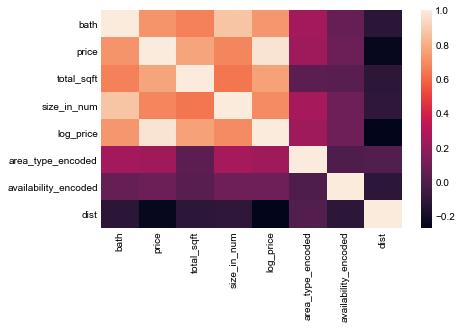

In [370]:
sns.heatmap(df_corr.corr())

From the above correlation map, we can understand, that following are highly correlated columns with log_price:<br>
bath/total_sqft/size_in_num/society

And these are the columns which have less correlation, hence insignificant:<br>
dist/availability_encoded/area_type_encoded

These non significant columns can be dropped in the future.

In [372]:
# The avg_rent is mostly NotFound. So this column can be dropped as well
df_5 = df_3.drop(columns=['area_type','availability','location'])
# Another reason for dropping dist is, the test data has lot of missing rows for this column, and we dont have
# enough information to do proper imputation for this col.

df_5.head()

,bath,price,total_sqft,size_in_num,log_price,area_type_encoded,availability_encoded,dist
0,2.000000,39.07,7.006362,2.0,3.665355,2,0,19.3
1,4.190557,120.00,7.863267,4.0,4.787492,3,1,34.6
2,2.000000,62.00,7.272398,3.0,4.127134,1,1,12.9
3,3.000000,95.00,7.327123,3.0,4.553877,2,1,21.4
4,2.000000,51.00,7.090077,2.0,3.931826,2,1,11.8


## NOW that ENCODING is COMPLETED, LETS START MODEL BUILDING

In [373]:
X = df_5.drop(columns=["log_price","price"])
out = df_5["log_price"]
X_c = sm.add_constant(X)
mod = sm.OLS(out, X_c)
ols_mod_1 = mod.fit()
ols_mod_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     4476.
Date:                Thu, 29 Sep 2022   Prob (F-statistic):               0.00
Time:                        17:20:46   Log-Likelihood:                -3687.0
No. Observations:               10590   AIC:                             7388.
Df Residuals:                   10583   BIC:                             7439.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -4.3657      0.107    -40.809      0.000      -4.575      -4.156
bath                     0.1844      0.008     22.222      0.000       0.168       0.201
total_sqft               1.0980      0.016     70.663      0.000       1.068       1.128
size_in_num              0.0869      0.008     10.408      0.000       0.071       0.103
area_type_encoded        0.1396      0.006     23.814      0.000       0.128       0.151
availability_encoded     0.0540      0.008      6.434      0.000       0.038       0.070
dist                    -0.0177      0.001    -30.911      0.000      -0.019      -0.017
==============================================================================
Omnibus:                      397.244   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              749.304
Skew:                           0.290   Prob(JB):                    1.95e-163
Kurtosis:                       4.167   Cond. No.                         586.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [374]:
from statsmodels.tools.eval_measures import rmse

y_log_pred = ols_mod_1.predict()
ols_1_rmse = rmse(y_log_pred, out)
ols_1_rmse

0.3427403735080548

In [375]:
y_pred = np.exp(y_log_pred)
ols_1_rmse_without_log = rmse(y_pred, df_5['price'])
ols_1_rmse_without_log

35.73061334245453

In [376]:
df_results = pd.DataFrame(columns=["model-type", "model-name", "ADJ-R-SQUARE", "RMSE-LOG", "RMSE-NORMAL"])
dict_results = {"model-type": "OLS", "model-name": "ols_mod_1", "ADJ-R-SQUARE": ols_mod_1.rsquared_adj, "RMSE-LOG": ols_1_rmse, "RMSE-NORMAL": ols_1_rmse_without_log}
df_results = df_results.append(dict_results, ignore_index=True)
df_results

,model-type,model-name,ADJ-R-SQUARE,RMSE-LOG,RMSE-NORMAL
0,OLS,ols_mod_1,0.717189,0.34274,35.730613


In [377]:
# Calculating VIF
def calculate_vif(inp):
    vif = pd.DataFrame()
    vif['VIF'] = [variance_inflation_factor(inp.values, i) for i in range(inp.shape[1])]
    vif['Columns'] = inp.columns
    return vif.sort_values('VIF', ascending=False)

In [378]:
# Using SKLEARN Linear regression and splitting the test data into train and test:
X = df_5.copy()
X_1 = X.drop(columns=["log_price","price"])
xtrain,xtest,ytrain,ytest=train_test_split(X,out,test_size=0.25,random_state=27)
xtrain_1 = xtrain.drop(columns=["log_price","price"])
xtest_1 = xtest.drop(columns=["log_price","price"])

lr = LinearRegression()
lr.fit(xtrain_1,ytrain)

ypred=lr.predict(xtrain_1)
r_square_train = r2_score(ytrain,ypred)
ad_r_square_train = 1 - ( 1-lr.score(xtrain_1,ytrain) ) * ( len(ytrain) - 1 ) / ( len(ytrain) - xtrain_1.shape[1] - 1 )
mse_train = mean_squared_error(ytrain,ypred)
rmse_train = rmse(ytrain,ypred)
rmse_normal = rmse(xtrain['price'],np.exp(ypred))

In [379]:
dict_results = {"model-type": "LinearRegression", "model-name": "lr", "ADJ-R-SQUARE": ad_r_square_train, "RMSE-LOG": rmse_train, "RMSE-NORMAL": rmse_normal}
df_results = df_results.append(dict_results, ignore_index=True)
df_results

,model-type,model-name,ADJ-R-SQUARE,RMSE-LOG,RMSE-NORMAL
0,OLS,ols_mod_1,0.717189,0.342740,35.730613
1,LinearRegression,lr,0.717342,0.342497,35.701080


In [380]:
ypred=lr.predict(xtest_1)
r_square_test = r2_score(ytest,ypred)
mse_test = mean_squared_error(ytest,ypred)
rmse_test = rmse(ytest,ypred)
rmse_test_normal = rmse(xtest['price'],np.exp(ypred))
rmse_test, rmse_test_normal

(0.3436932766414366, 36.42370836384102)

In [381]:
# It is not a huge difference, but lets try using Cross_va_score
score = cross_val_score(lr,X_1,out,cv=8,scoring='r2')

avg_score=score.mean()
coeff_of_variance = score.std()/score.mean()
coeff_of_variance

0.023166562753474992

 Coefficient of variation is less than 2 percent

In [382]:
# Optimizing number of features in OLS model
from itertools import combinations

column_list = X_1.columns
interactions = list(combinations(column_list, 2))

interaction_dict = {}
for interaction in interactions:
    int_2_cols = X_1.copy()
    int_2_cols['int'] = int_2_cols[interaction[0]] * int_2_cols[interaction[1]]
    lr = LinearRegression()
    lr.fit(int_2_cols, out)
    interaction_dict[lr.score(int_2_cols, out)] = interaction

top_5 = sorted(interaction_dict.keys(), reverse = True)[:5]
for interaction in top_5:
    print(interaction, interaction_dict[interaction])
column_list

0.724387927464081 ('bath', 'total_sqft')
0.7243771212775352 ('total_sqft', 'size_in_num')
0.719343462795176 ('size_in_num', 'area_type_encoded')
0.7189875600608868 ('bath', 'area_type_encoded')
0.7179557233730121 ('availability_encoded', 'dist')


Index(['bath', 'total_sqft', 'size_in_num', 'area_type_encoded',
       'availability_encoded', 'dist'],
      dtype='object')

In [383]:
column_list = X_1.columns
interactions = list(combinations(column_list, 3))
interaction_dict = {}
for interaction in interactions:
    int_3_cols = X_1.copy()
    int_3_cols['int'] = int_3_cols[interaction[0]] * int_3_cols[interaction[1]] * int_3_cols[interaction[2]]
    lr1 = LinearRegression()
    lr1.fit(int_3_cols, out)
    interaction_dict[lr1.score(int_3_cols, out)] = interaction

top_5 = sorted(interaction_dict.keys(), reverse = True)[:5]
for interaction in top_5:
    print(interaction, interaction_dict[interaction])
column_list

0.7186426323262187 ('size_in_num', 'area_type_encoded', 'availability_encoded')
0.7184560951102669 ('bath', 'size_in_num', 'area_type_encoded')
0.7184230385449708 ('bath', 'total_sqft', 'size_in_num')
0.7181794107851158 ('bath', 'area_type_encoded', 'availability_encoded')
0.7181412574648585 ('total_sqft', 'size_in_num', 'area_type_encoded')


Index(['bath', 'total_sqft', 'size_in_num', 'area_type_encoded',
       'availability_encoded', 'dist'],
      dtype='object')

In [384]:
column_list = X_1.columns
interactions = list(combinations(column_list, 4))
interaction_dict = {}
for interaction in interactions:
    int_4_cols = X_1.copy()
    int_4_cols['int'] = int_4_cols[interaction[0]] * int_4_cols[interaction[1]] * int_4_cols[interaction[2]] * int_4_cols[interaction[3]]
    lr = LinearRegression()
    lr.fit(int_4_cols, out)
    interaction_dict[lr.score(int_4_cols, out)] = interaction

top_5 = sorted(interaction_dict.keys(), reverse = True)[:5]
for interaction in top_5:
    print(interaction, interaction_dict[interaction])

0.7183319013220532 ('bath', 'size_in_num', 'area_type_encoded', 'availability_encoded')
0.7180775612969794 ('total_sqft', 'size_in_num', 'area_type_encoded', 'availability_encoded')
0.7179919514277624 ('bath', 'size_in_num', 'area_type_encoded', 'dist')
0.7178002416296452 ('total_sqft', 'size_in_num', 'area_type_encoded', 'dist')
0.7177891391725275 ('bath', 'total_sqft', 'area_type_encoded', 'dist')


The combination of these columns stand out:

0.7460162223342399 ('society', 'bath', 'total_sqft')

In [385]:
"""So now we have two additional features:
    Product of ('bath', 'size_in_num', 'area_type_encoded')
    and ('society', 'dist')
"""
X_1 = X.copy()
X_1['3_col_interaction'] = X['bath']*X['total_sqft']


In [386]:
X_1.head()

,bath,price,total_sqft,size_in_num,log_price,area_type_encoded,availability_encoded,dist,3_col_interaction
0,2.000000,39.07,7.006362,2.0,3.665355,2,0,19.3,14.012723
1,4.190557,120.00,7.863267,4.0,4.787492,3,1,34.6,32.951468
2,2.000000,62.00,7.272398,3.0,4.127134,1,1,12.9,14.544797
3,3.000000,95.00,7.327123,3.0,4.553877,2,1,21.4,21.981370
4,2.000000,51.00,7.090077,2.0,3.931826,2,1,11.8,14.180154


In [387]:
# Now that we have all the columns, lets try to get rid of them using Feature Elimination
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

# Backward feature Elimination
X_2 = X_1.drop(columns=["price","log_price"])
lr = LinearRegression()
lr_back = sfs(estimator=lr, k_features='best', scoring='r2', forward=False)
sfs_back = lr_back.fit(X_2, out)
backward_selection_features = list(sfs_back.k_feature_names_)

ad_r_square = 1 - ( 1-sfs_back.k_score_) * ( len(out) - 1 ) / ( len(out) - X_2.shape[1] - 1 )
# ypred= sfs_back.predict(X_2)

backward_selection_features, sfs_back.k_score_

(['bath',
  'total_sqft',
  'size_in_num',
  'area_type_encoded',
  'availability_encoded',
  'dist',
  '3_col_interaction'],
 0.7237118823301152)

In [79]:
# rmse_log = rmse(out, ypred)
# rmse_test_normal = rmse(X_1['price'],np.exp(ypred))

# dict_results = {"model-type": "LinearRegression-SFS-BACK", "model-name": "sfs_back", "ADJ-R-SQUARE": ad_r_square, "RMSE-LOG": rmse_train, "RMSE-NORMAL": rmse_normal}
# df_results = df_results.append(dict_results, ignore_index=True)
# df_results

In [388]:
# Forward feature Elimination
lr = LinearRegression()
lr_for = sfs(estimator=lr, k_features='best', scoring='r2', forward=True)
sfs_for = lr_for.fit(X_2, out)
forward_selection_features = list(sfs_for.k_feature_names_)
forward_selection_features, sfs_back.k_score_

(['bath',
  'total_sqft',
  'size_in_num',
  'area_type_encoded',
  'availability_encoded',
  'dist',
  '3_col_interaction'],
 0.7237118823301152)

In [389]:
# Using RFECV for feature elimination
from sklearn.feature_selection import RFECV

lr = LinearRegression()
rfecv_obj = RFECV(estimator=lr,cv=5,min_features_to_select=1, step=1)
rfecv_mod = rfecv_obj.fit(X=X_2, y=out)
rfecv_mod.ranking_

array([1, 1, 1, 1, 1, 1, 1])

In [390]:
# Retaining all the columns
# Calculating the RMSE with the new features
xtrain,xtest,ytrain,ytest=train_test_split(X_1,out,test_size=0.20,random_state=27)
xtrain_1 = xtrain.drop(columns=["log_price", "price"])
xtest_1 = xtest.drop(columns=["log_price", "price"])

lr_3 = LinearRegression()
lr_3.fit(xtrain_1,ytrain)

ypred=lr_3.predict(xtrain_1)
r_square_train = r2_score(ytrain,ypred)
mse_train = mean_squared_error(ytrain,ypred)

ad_r_square = 1 - ( 1-r_square_train) * ( len(ytrain) - 1 ) / ( len(ytrain) - xtrain_1.shape[1] - 1 )
rmse_train_log = rmse(ytrain,ypred)
rmse_train_normal = rmse(xtrain['price'], np.exp(ypred))

dict_results = {"model-type": "LinearRegression", "model-name": "lr_3", "ADJ-R-SQUARE": ad_r_square, "RMSE-LOG": rmse_train_log, "RMSE-NORMAL": rmse_train_normal}
df_results = df_results.append(dict_results, ignore_index=True)
df_results


,model-type,model-name,ADJ-R-SQUARE,RMSE-LOG,RMSE-NORMAL
0,OLS,ols_mod_1,0.717189,0.342740,35.730613
1,LinearRegression,lr,0.717342,0.342497,35.701080
2,LinearRegression,lr_3,0.723601,0.339205,32.533635


In [391]:
ypred=lr_3.predict(xtest_1)
r_square_test = r2_score(ytest,ypred)
mse_test = mean_squared_error(ytest,ypred)
rmse_test = rmse(ytest,ypred)
r_square_test, rmse_test

(0.7264655268924073, 0.33550353298838276)

These scores are better than before we added new columns. But the test score is little bad as compared to the train score. This can be considered Overfitting. Using Grid Search CV to find the best Hyperparameter:

In [392]:
hyp_param = {'alpha':[0,0.1,1,2], 'l1_ratio':[0.000001, 0.001, 0.155, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 0.999, 1]}
enet = ElasticNet(normalize=True)
hyper_model = GridSearchCV(estimator=enet, param_grid=hyp_param, cv=5, scoring='r2')

tun_model = hyper_model.fit(X_2, out)
print(f"Best Hyper Parameter: {tun_model.best_params_}")
print(f"Best Score: {tun_model.best_score_}")
res = pd.DataFrame(tun_model.cv_results_)

Best Hyper Parameter: {'alpha': 0, 'l1_ratio': 1e-06}
Best Score: 0.7233335516693598


We will be using RFECV model(lr_3) for our further usage.

In [393]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor

In [395]:
def find_best_model_using_gridsearchcv(X, y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [0.1, 0.3, 0.5],
                'selection': ['random', 'cyclic']
            }
        },
        'ridge': {
            'model': Ridge(),
            'params': {
                'alpha': [0.2, 0.7, 0.9]
            }
        },
        'random_forest': {
            'model': RandomForestRegressor(),
            'params': {
                'n_estimators': [50, 100, 300, ], 'max_depth': [10, 15, 20, 25], 
            }
        },
        'xgboost': {
            'model': XGBRegressor(),
            'params': {
                'n_estimators': [50, 80, 100], 
            }
        }

    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X_2, out)

,model,best_score,best_params
0,linear_regression,0.725947,{'normalize': False}
1,lasso,0.610142,"{'alpha': 0.1, 'selection': 'random'}"
2,ridge,0.725924,{'alpha': 0.2}
3,random_forest,0.788807,"{'max_depth': 15, 'n_estimators': 300}"
4,xgboost,0.801489,{'n_estimators': 80}


In [396]:
dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_2, out)
dt_reg.score(X_2, out)

0.9590148772233541

23.235135942172587

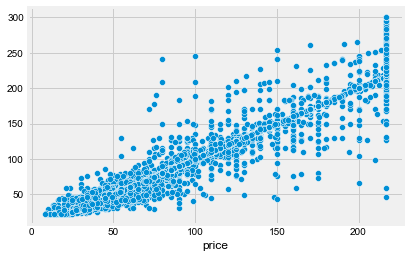

In [397]:
y_pred_log = dt_reg.predict(X_2)
y_pred = np.exp(y_pred_log)
sns.scatterplot(x=X_1['price'], y=y_pred)
rmse_dt = rmse(y_pred, X_1['price'])
rmse_dt
# sns.scatterplot(x=y, y=y_pred)

In [398]:
rf_reg = RandomForestRegressor(n_estimators=300, max_depth=15)
rf_reg.fit(X_2, out)
rf_reg.score(X_2, out)

0.914048645199588

23.106929118618375

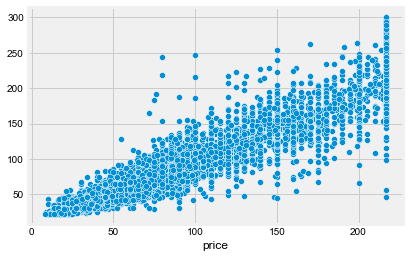

In [399]:
y_pred_log = rf_reg.predict(X_2)
y_pred = np.exp(y_pred_log)
sns.scatterplot(x=X_1['price'], y=y_pred)
rmse_rf = rmse(y_pred, X_1['price'])
rmse_rf

In [400]:
gb_reg = GradientBoostingRegressor(n_estimators=100)
gb_reg.fit(X_2, out)
gb_reg.score(X_2, out)

0.7944372457938191

30.039322429611353

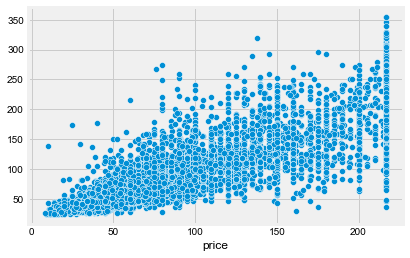

In [401]:
y_pred_log = gb_reg.predict(X_2)
y_pred = np.exp(y_pred_log)
sns.scatterplot(x=X_1['price'], y=y_pred)
rmse_gb = rmse(y_pred, X_1['price'])
rmse_gb

In [402]:
xgb_reg = XGBRegressor(n_estimators=80)
xgb_reg.fit(X_2, out)
xgb_reg.score(X_2, out)

0.8793885781179888

25.301817003889425

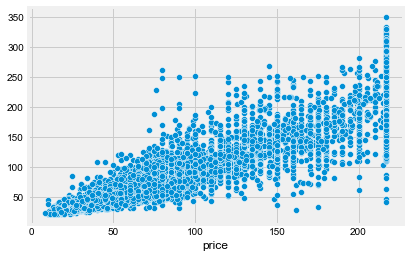

In [403]:
y_pred_log = xgb_reg.predict(X_2)
y_pred = np.exp(y_pred_log)
sns.scatterplot(x=X_1['price'], y=y_pred)
rmse_xgb = rmse(y_pred, X_1['price'])
rmse_xgb

In [404]:
est = HistGradientBoostingRegressor().fit(X_2, out)
est.score(X_2, out)

0.8309310791191884

27.891479065957995

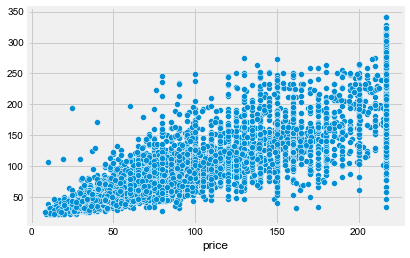

In [405]:
y_pred_log = est.predict(X_2)
y_pred = np.exp(y_pred_log)
sns.scatterplot(x=X_1['price'], y=y_pred)
rmse_hgbr = rmse(y_pred, X_1['price'])
rmse_hgbr

## Repeating the same preprocesing steps for test

In [406]:
df_test = pd.read_csv("test.csv")
df_test.drop(columns=["ID", "balcony"], inplace=True)
df_test.head()

,area_type,availability,location,size,society,total_sqft,bath
0,Super built-up Area,Ready To Move,Chamrajpet,2 BHK,NaN,650,1.0
1,Super built-up Area,Ready To Move,7th Phase JP Nagar,3 BHK,SrncyRe,1370,2.0
2,Super built-up Area,Ready To Move,Whitefield,3 BHK,AjhalNa,1725,3.0
3,Built-up Area,Ready To Move,Jalahalli,2 BHK,NaN,1000,2.0
4,Plot Area,Ready To Move,TC Palaya,1 Bedroom,NaN,1350,1.0


In [407]:
df_test["bath"].fillna(0, inplace=True)
df_test["total_sqft_1"] = df_test["total_sqft"].apply(units_in_sq_ft)
df_test.drop(columns=["total_sqft"], inplace=True)
df_test.rename(columns={"total_sqft_1":"total_sqft"},inplace=True)

df_test['society'].fillna("Independent", inplace=True)
df_test['size'].fillna(0, inplace=True)
df_test['size_in_num'] = df_test['size'].apply(get_room_count)

<AxesSubplot:xlabel='size_in_num', ylabel='count'>

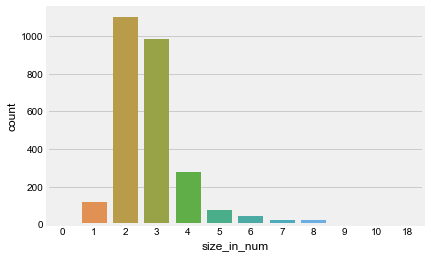

In [408]:
sns.countplot(x='size_in_num', data=df_test)

In [409]:
IQR = df_test.quantile(0.75) - df_test.quantile(0.25)
df_mean = df_test.mean()
IQR = pd.DataFrame(IQR)
df_mean = pd.DataFrame(df_mean)

df_test_1 = df_test.select_dtypes(include=np.number)

for col in df_test_1:

    df_test_1[col] = df_test_1[col].apply(
        lambda x:(
            df_mean.loc[col].values[0] - 1.5*IQR.loc[col].values[0]) if x < (df_mean.loc[col].values[0] - 1.5*IQR.loc[col].values[0]) else (df_mean.loc[col].values[0] + 1.5*IQR.loc[col].values[0]) if x > df_mean.loc[col].values[0] + 1.5*IQR.loc[col].values[0] else x
    )
df_test_1.head()

,bath,total_sqft,size_in_num
0,1.192568,816.568146,2.000000
1,2.000000,1370.000000,3.000000
2,3.000000,1725.000000,3.000000
3,2.000000,1000.000000,2.000000
4,1.192568,1350.000000,1.310435


In [410]:
df_test_2 = df_test.select_dtypes(exclude=np.number)
df_test_2.drop(columns=["size"],inplace=True)
df_test_2.rename(columns={'size_in_num':'size'})
df_test_1['total_sqft'] = np.log(df_test['total_sqft'])
ordinal_encoding_area_dict = {"Carpet  Area":0, "Built-up  Area":1, "Plot  Area":3, "Super built-up  Area":2}
df_test_2['area_type_encoded'] = df_test_2['area_type'].map(ordinal_encoding_area_dict)
df_test_2['availability_encoded'] = df_test_2['availability'].apply(lambda x: 1 if x=="Ready To Move" else 0)

In [411]:
df_society_enc = target_en.transform(df_test_2['society'])
df_test_2 = df_society_enc.join(df_test_2.drop(columns="society"))

df_test_2.drop(columns=['area_type', 'availability', 'location'], inplace=True)

df_test_3 = pd.concat([df_test_1, df_test_2], axis=1)
df_test_3.head()

,bath,total_sqft,size_in_num,society,area_type_encoded,availability_encoded
0,1.192568,6.476972,2.000000,4.428872,2,1
1,2.000000,7.222566,3.000000,3.820060,2,1
2,3.000000,7.452982,3.000000,4.371630,2,1
3,2.000000,6.907755,2.000000,4.428872,1,1
4,1.192568,7.207860,1.310435,4.428872,3,1


In [412]:
df_test_3.isna().sum()

bath                    0
total_sqft              0
size_in_num             0
society                 0
area_type_encoded       0
availability_encoded    0
dtype: int64

In [413]:
df_test_4 = df_test_3.copy()
df_test_4['3_col_interaction'] = df_test_3['society']*df_test_3['bath']*df_test_3['total_sqft']
df_test_4.head()

,bath,total_sqft,size_in_num,society,area_type_encoded,availability_encoded,3_col_interaction
0,1.192568,6.476972,2.000000,4.428872,2,1,34.209613
1,2.000000,7.222566,3.000000,3.820060,2,1,55.181277
2,3.000000,7.452982,3.000000,4.371630,2,1,97.745049
3,2.000000,6.907755,2.000000,4.428872,1,1,61.187128
4,1.192568,7.207860,1.310435,4.428872,3,1,38.069963


In [414]:
y = lr_3.predict(df_test_4)

In [415]:
df_sol = pd.DataFrame()
y_1 = np.exp(y)
df_sol['price'] = y_1
df_sol.index.name='ID'
df_sol.head()

,price
ID,
0,0.071576
1,0.009990
2,0.000006
3,0.001357
4,0.115521


In [416]:
df_sol.to_csv("sol.csv")

In [417]:
df_sol.shape

(2664, 1)

In [418]:
y_GSCV = tun_model.predict(df_test_4)
df_sol_1 = pd.DataFrame()
y_GSCV_normal = np.exp(y_GSCV)
df_sol_1['price'] = y_GSCV_normal
df_sol_1.index.name='ID'
df_sol_1.head()

,price
ID,
0,0.301116
1,0.080964
2,0.000278
3,0.015742
4,0.521511


In [419]:
df_sol_1.to_csv("sol_GSCV.csv")

In [420]:
y_dt = dt_reg.predict(df_test_4)
df_sol_1 = pd.DataFrame()
y_dt_normal = np.exp(y_dt)
df_sol_1['price'] = y_dt_normal
df_sol_1.index.name='ID'
df_sol_1.head()

,price
ID,
0,180.0
1,300.0
2,300.0
3,180.0
4,300.0


In [421]:
df_sol_1.to_csv("sol_DT.csv")

In [422]:
y_rf = rf_reg.predict(df_test_4)
df_sol_1 = pd.DataFrame()
y_rf_normal = np.exp(y_rf)
df_sol_1['price'] = y_rf_normal
df_sol_1.index.name='ID'
df_sol_1.head()

,price
ID,
0,173.919604
1,218.430046
2,240.193393
3,173.919604
4,217.555190


In [423]:
df_sol_1.to_csv("sol_RF.csv")

In [424]:
y_gb = gb_reg.predict(df_test_4)
df_sol_1 = pd.DataFrame()
y_gb_normal = np.exp(y_gb)
df_sol_1['price'] = y_gb_normal
df_sol_1.index.name='ID'
df_sol_1.head()

,price
ID,
0,206.911714
1,237.642296
2,258.809019
3,206.911714
4,189.286935


In [425]:
df_sol_1.to_csv("sol_GB.csv")

In [426]:
y_xgb = xgb_reg.predict(df_test_4)
df_sol_1 = pd.DataFrame()
y_xgb_normal = np.exp(y_xgb)
df_sol_1['price'] = y_xgb_normal
df_sol_1.index.name='ID'
df_sol_1.head()

,price
ID,
0,144.841476
1,216.913452
2,216.484955
3,148.139328
4,141.476700


In [427]:
df_sol_1.to_csv("sol_XGB.csv")

In [428]:
y_hgbr = est.predict(df_test_4)
df_sol_1 = pd.DataFrame()
y_hgbr_normal = np.exp(y_hgbr)
df_sol_1['price'] = y_hgbr_normal
df_sol_1.index.name='ID'
df_sol_1.head()

,price
ID,
0,176.961530
1,248.351461
2,281.518093
3,173.492845
4,236.092383


In [429]:
df_sol_1.to_csv("sol_HGBR.csv")